<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/LLaVa/Inference_with_LLaVa_for_multimodal_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%ls

drive/  sample_data/


In [3]:
%cd drive/MyDrive/SketchToReality/

/content/drive/MyDrive/SketchToReality


In [4]:
%ls

Data/  Dataset/  data_viusalization_colab.ipynb  utils/


# Inference with LLaVa, a multimodal LLM

LLaVa is an exciting new multimodal LLM which extends large language models like [LLaMa](https://huggingface.co/docs/transformers/model_doc/llama) with visual inputs.

For multimodal LLMs, one typically takes a pre-trained/fine-tuned LLM and additionally conditions it on image features. In case of LLaVa, the image features come from a pre-trained [CLIP](https://huggingface.co/docs/transformers/model_doc/clip)'s vision encoder. To match the dimension of the image features with those of the text features, one applies a projection module, which could be a simple linear projection (like the original LLaVa), or more sophisticated like a two-layer MLP (used in LLaVa 1.5).

One then trains the model to predict the next text token, given image features and text tokens.

![image/png](https://cdn-uploads.huggingface.co/production/uploads/62441d1d9fdefb55a0b7d12c/FPshq08TKYD0e-qwPLDVO.png)

* Transformers docs: https://huggingface.co/docs/transformers/main/en/model_doc/llava.
* Original LLaVa paper: https://arxiv.org/abs/2304.08485
* LLaVa 1.5 paper: https://arxiv.org/pdf/2310.03744.pdf
* [notebook](https://colab.research.google.com/drive/1qsl6cd2c8gGtEW1xV5io7S8NHh-Cp1TV?usp=sharing#scrollTo=6Bx8iu9jOssW) which inspired me to create this notebook.

## Set-up environment

Let's start by installing the necessary libraries. Here we install Accelerate and Bitsandbytes in order to load the model in Google Colab. This enables [4-bit inference](https://huggingface.co/blog/4bit-transformers-bitsandbytes) with clever quantization techniques, shrinking the size of the model considerably, while maintaining performance of the original size.

In [5]:
!pip install --upgrade -q accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 10.3 MB/s eta 0:00:00


We also update the Transformers version of Google Colab to use the main branch, as the model is brand new at the time of writing.

In [6]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-g47s1s2u
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-g47s1s2u
  Resolved https://github.com/huggingface/transformers.git to commit 1a77f07f6556b1482bd5e5f8399aa528727d1b47
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.39.0.dev0-py3-none-any.whl size=8514199 sha256=6aaaa45121a19e2a1f333c6568cada6daef0c748a9fe28885293ffb8480c3585
  Stored in directory: /tmp/pip-ephem-wheel-cache-2drm0duh/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.37.2
    Uninstalling transformers-4.37.2:
      Successfully uninstalled transformers-4.37.2


## Load model and processor

Next, we load a model and corresponding processor from the hub. We specify device_map="auto" in order to automatically place the model on the available GPUs/CPUs (see [this guide](https://huggingface.co/docs/accelerate/usage_guides/big_modeling) for details).

Regarding [quantization](https://huggingface.co/blog/4bit-transformers-bitsandbytes), refer to the blog post for all details.

In [7]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)


model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, quantization_config=quantization_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

## Prepare image and text for the model

In [8]:
from PIL import Image
import os
import numpy as np
import glob

sketch_path = './Data/data/sketch/tx_000000000000/*/*'
list_all_files = []
for file in glob.glob(sketch_path, recursive=True):
    list_all_files.append(file)

Label: candle


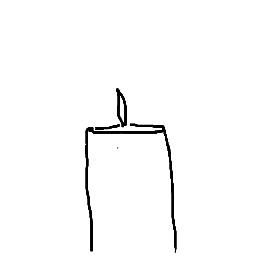

In [9]:
random_sketch_idx = np.random.randint(0, len(list_all_files))
random_sketch_path = list_all_files[random_sketch_idx]
label = random_sketch_path.split(sep='/')[-2]
RandomSketch = Image.open(random_sketch_path)
print(f'Label: {label}')
display(RandomSketch)

In the prompt, you can refer to images using the special \<image> token. To indicate which text comes from a human vs. the model, one uses USER and ASSISTANT respectively. The format looks as follows:

```bash
USER: <image>\n<prompt>\nASSISTANT:
```

In other words, you always need to end your prompt with `ASSISTANT:`. Here we will perform batched generation (i.e generating on several prompts).

In [10]:
prompts = [
            "USER: <image>\nWhat is drawn in this art sketch?\nASSISTANT:",
            "USER: <image>\nIs there a particular style effect in this art sketch ?\nASSISTANT:"
]

# Input as many prompts as images (does not automatically scale)
inputs = processor(prompts, images=[RandomSketch, RandomSketch], padding=True, return_tensors="pt").to("cuda")
for k,v in inputs.items():
  print(k,v.shape)

input_ids torch.Size([2, 24])
attention_mask torch.Size([2, 24])
pixel_values torch.Size([2, 3, 336, 336])


## Autoregressively generate completion

Finally, we simply let the model predict the next tokens given the images + prompt. Of course one can adjust all the [generation parameters](https://huggingface.co/docs/transformers/v4.35.2/en/main_classes/text_generation#transformers.GenerationMixin.generate). By default, greedy decoding is used.

In [11]:
output = model.generate(**inputs, max_new_tokens=100)
generated_text = processor.batch_decode(output, skip_special_tokens=True) # Greedy decoding
for text in generated_text:
  print(text.split("ASSISTANT:")[-1])

 In this art sketch, a candle is drawn. The candle is depicted with a flame, and it is placed in a candle holder. The image is in black and white, giving it a classic and timeless appearance.
 Yes, there is a particular style effect in this art sketch. The image is a black and white drawing of a lit candle, which gives it a more dramatic and artistic appearance. The contrast between the white candle and the black background adds to the visual impact of the drawing. This style effect can evoke a sense of nostalgia or emphasize the simplicity and elegance of the subject matter.


## Evaluating on a batch of images to evaluate Llava

In [ ]:
# # Transform batch of image of our dataset to list to feed to Llava

# def batch_toPILlist(batch, dataset, show_batch = True): # batch is a list of tensors
#     topil = transforms.ToPILImage()
#     classes = dataset.classes
#     PIL_list = []
#     labels = []
#     for i in range(len(batch[0])):
#         image = batch[0][i].cpu().numpy()
#         image = image.transpose((1, 2, 0))
#         image = (image * 255.0).astype("uint8")
#         PILimage = topil(image)
#         # grab the label id and get the label from the classes list
#         idx = batch[1][i]
#         label = classes[idx] # In the DataLoader class
#         PIL_list.append(PILimage)
#         labels.append(label)

#     if show_batch:
#         visualize_batch(batch, classes, "")
#     return PIL_list, labels

In [14]:
import pandas as pd
def dataframe_toPILlist(df, show_img = False):
    image_list = []
    label_list = []
    for i in range(df.shape[0]):
        row = df.iloc[i]
        path = row['path']
        lab = row['label']

        img = Image.open(path)
        image_list.append(img)
        label_list.append(lab)

        if show_img:
            print(f'\nLabel {lab}')
            display(img)

    return image_list, label_list

In [ ]:
eval_file = './Data/data/sketch/eval_image_captioning.csv'
eval_dataframe = pd.read_csv(eval_file)
PILimages, labels = dataframe_toPILlist(eval_dataframe, show_img=True)

In [33]:
def evaluate_llava(img_list, label_list, eval_prompt = ["USER: <image>\nWhat is drawn in this art sketch?\nASSISTANT:"], display = False):

  results = []
  if len(eval_prompt) > 1:
    print("For evaluation, please input only 1 prompt to check if label is in the generated answer")
    return 0

  for i in range(len(img_list)):
    sketch = [img_list[i]]
    label = label_list[i]
    # Input as many prompts as images (does not automatically scale)
    inputs = processor(eval_prompt, images=sketch, padding=True, return_tensors="pt").to("cuda")
    output = model.generate(**inputs, max_new_tokens=100)
    generated_text = processor.batch_decode(output, skip_special_tokens=True) # Greedy decoding
    for text in generated_text:
      answer = text.split("ASSISTANT:")[-1]

    if(display):
      display(sketch[0])
    if label in answer:
      results.append(1)
      print(f'\nLabel {label} found in answer:{answer}')
      print('True')
    else:
      results.append(0)
      print(f'\nLabel {label} not found in answer:{answer}')
      print('False')

  acc = np.mean(results)
  print(f'Accuracy of Llava1.5: {acc}')
  return acc

In [34]:
accuracy_llava = evaluate_llava(PILimages, labels)


Label car_(sedan) not found in answer: In this art sketch, a car is drawn.
False

Label bicycle found in answer: In this art sketch, a bicycle is drawn.
True

Label ape not found in answer: In this art sketch, a person is depicted holding a stick or a pole. The person is wearing a hat and appears to be a naked figure. The drawing is a simple, black and white sketch, which highlights the contrast between the figure and the background.
False

Label racket not found in answer: In this art sketch, a magnifying glass is drawn.
False

Label windmill found in answer: In this art sketch, a windmill is drawn.
True

Label rifle not found in answer: In this art sketch, a gun is drawn.
False

Label dolphin found in answer: In this art sketch, a dolphin is drawn.
True

Label fan found in answer: In this art sketch, a fan or a propeller is drawn. The fan is shown with its blades, and it appears to be a simple, black and white drawing. The focus of the sketch is on the fan, with no other objects or 